In [2]:
import pandas as pd 
from utils import extract_colors_image,extract_colors_url

In [3]:
url=extract_colors_url("https://nestorevintage.fr/cdn/shop/files/307FDA5D-D3FB-48D6-8DA2-2478DF104BD3.jpg?v=1738348432&width=2048")

c:\Users\BahaARFAOUI\OneDrive - CBTW\Bureau\colorfact\colorfact\utils.py:80: RuntimeWarning: overflow encountered in scalar subtract
  a_std = float(a_opencv - 128)


In [4]:
url.colors

[[58.03921568627452, 251.0, 26.0], [46.27450980392157, 253.0, 23.0]]

In [4]:
image=extract_colors_image(image_path="data/doudoune.png")

In [5]:
image.colors

[[40.3921568627451, -7.0, 6.0], [23.52941176470588, -7.0, 6.0]]

In [6]:
im=image.remove_background_grabcut()

In [20]:
import pandas as pd
data=pd.read_excel("data/final_data.xlsx")

In [21]:
data=data.drop("Unnamed: 0",axis=1)

In [5]:
import pandas as pd
import concurrent.futures
from tqdm import tqdm

def process_image(image_url):
    """Extracts dominant colors from an image URL."""
    try:
        color_extractor = extract_colors_url(image_url)
        return color_extractor.colors
    except Exception as e:
        print(f"Error processing {image_url}: {str(e)}")
        return None

def process_dataset(df: pd.DataFrame, num_workers=8) -> pd.DataFrame:
    """
    Processes a dataset containing image links and adds a 'cielab_colors' column
    with the dominant colors extracted from each image using multithreading.

    Args:
        df (pd.DataFrame): Input dataframe containing a 'Photo produit' column.
        num_workers (int): Number of threads for parallel processing.

    Returns:
        pd.DataFrame: Modified dataframe with 'cielab_colors' column added.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")

    if 'Photo produit 1' not in df.columns:
        raise ValueError("DataFrame must contain a 'Photo produit' column")

    image_urls = df['Photo produit 1'].tolist()

    # Process images in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(tqdm(executor.map(process_image, image_urls), total=len(image_urls)))

    df['cielab_colors'] = results
    return df

# Example usage:
#df_processed = process_dataset(df_corrected, num_workers=8)


In [14]:
df_processed_2=data.iloc[1150:1350,:]

In [ ]:
df_processed_2_pro = process_dataset(df_processed_2, num_workers=8)


  0%|          | 0/200 [00:00<?, ?it/s]

 36%|███▌      | 72/200 [59:01<4:59:47, 140.53s/it]

Error processing https://images.stockx.com/images/New-Balance-M2002-Protection-Pack-Rain-Cloud-Product.jpg?fit=fill&bg=FFFFFF&w=140&h=75&q=60&dpr=1&trim=color&updated_at=1738193358: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by KMeans.
Error processing https://images.stockx.com/images/New-Balance-1906R-White-Gold-Product.jpg?fit=fill&bg=FFFFFF&w=140&h=75&q=60&dpr=1&trim=color&updated_at=1738193358: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by KMeans.


 40%|████      | 80/200 [1:27:02<5:00:44, 150.37s/it] 

In [13]:
df_processed_2_pro.to_excel("data/data_1050_1150.xlsx")

In [3]:
import faiss 
import numpy as np 
import pandas as pd 

In [22]:
data_prev=pd.read_excel("data/data_preview_exploded.xlsx")

In [23]:
data_prev=data_prev.drop("Unnamed: 0",axis=1)

In [6]:
def lab_to_lch(lab):
        L, a, b = lab
        C = np.sqrt(a**2 + b**2)
        H = np.degrees(np.arctan2(b, a)) % 360  # Normalisation correcte
        return [L, C, H]

def lch_to_lab(lch):
    L, C, H = lch
    a = C * np.cos(np.radians(H))
    b = C * np.sin(np.radians(H))
    return [L, a, b]

def generate_harmonic_colors(input_colors_lab):

    input_colors_lch = [lab_to_lch(color) for color in input_colors_lab]
    num_colors = len(input_colors_lab)

    if num_colors == 1:
        L, C, H = input_colors_lch[0]
        triad1 = lch_to_lab([L, C, (H + 120) % 360])
        triad2 = lch_to_lab([L, C, (H + 240) % 360])
        return input_colors_lab + [triad1, triad2]

    elif num_colors == 2:
        chosen_idx = np.random.choice([0, 1])
        L, C, H = input_colors_lch[chosen_idx]
        complementary = lch_to_lab([L, C, (H + 180) % 360])
        return input_colors_lab + [complementary]

    elif num_colors == 3:
        chosen_indices = np.random.choice([0, 1, 2], size=2, replace=False)
        selected_colors = [input_colors_lab[i] for i in chosen_indices]
        return selected_colors

    return input_colors_lab

In [42]:
import yaml
from pyprojroot import here
with open(here("colorfact/configs/outfit.yaml")) as cfg:
    outfit = yaml.load(cfg, Loader=yaml.FullLoader)

In [8]:
data.columns

Index(['Photo produit 1', 'Photo produit 2 ', 'Nom produit ', 'Lien achat',
       'Catégorie produit', 'Genre', 'cielab_colors'],
      dtype='object')

In [115]:
import ast
import numpy as np
import faiss

def recommend_outfit(input_category, data, input_colors, outfit_type, ontology, top_k=3):
    try:
        required_items = ontology["Outfit"][input_category][outfit_type]
    except KeyError as e:
        raise ValueError(f"Invalid category or outfit type: {str(e)}")

    recommendations = {}
    similarity_threshold = 0.2  # 90% similarity

    # Generate harmonized colors for input
    input_colors = generate_harmonic_colors(input_colors)
    query_colors = np.array(input_colors, dtype="float32")
    faiss.normalize_L2(query_colors)

    for item_category in required_items:
        # Filter data for the given category
        filtered_data = data[data["Catégorie produit"] == item_category].copy()

        # Ensure cielab_colors is correctly formatted
        filtered_data["cielab_colors"] = filtered_data["cielab_colors"].apply(ast.literal_eval)
        filtered_data.dropna(inplace=True)
        filtered_data["cielab_colors"] = filtered_data["cielab_colors"].apply(tuple)
        filtered_data.drop_duplicates(inplace=True)

        # Convert to NumPy array
        vectors = np.array([list(t) for t in filtered_data["cielab_colors"]], dtype="float32")
        if vectors.shape[0] == 0:
            continue  # Skip if no data available

        # Normalize and create FAISS index
        faiss.normalize_L2(vectors)
        index = faiss.IndexFlatL2(vectors.shape[1])
        index.add(vectors)

        # Search for closest matches
        distances, indices = index.search(query_colors, top_k)

        seen_ids = set()
        matches = []

        for i in range(indices.shape[0]):
            for j in range(indices.shape[1]):
                idx = indices[i][j]
                if idx >= len(filtered_data) or distances[i][j] > similarity_threshold:
                    continue  # Skip invalid or low-similarity matches

                product_id = filtered_data.iloc[idx]["Photo produit 1"]
                if product_id not in seen_ids:
                    seen_ids.add(product_id)
                    matches.append({
                        "product_id": product_id,
                        "distance": distances[i][j],
                        "metadata": filtered_data.iloc[idx].to_dict(),
                    })
                
                if len(matches) >= top_k:
                    break  # Stop early if enough matches are found

        recommendations[item_category] = matches

    return recommendations


In [111]:
top_k=3
input_colors=[[49.80392156862745, -17.0, -10.0], [41.568627450980394, -16.0, -9.0]]


In [2]:
import json
import unidecode
from rapidfuzz import fuzz, process
from pyprojroot import here
with open(here("colorfact/mapping/product_mapping.json"), "r", encoding="utf-8") as f:
    saved_mapping = json.load(f)
# Load mapping dictionary
mapping = saved_mapping

# Normalize keys in mapping for case-insensitive lookup
normalized_mapping = {unidecode.unidecode(k.lower().strip()): v for k, v in mapping.items()}

# Function to normalize input
def normalize_text(text):
    text = text.lower().strip()  # Lowercase and remove extra spaces
    text = unidecode.unidecode(text)  # Remove accents (é -> e)
    text = text.replace("-", " ").replace("_", " ")  # Replace dashes and underscores with spaces
    return text

# Function to find best match using fuzzy matching
def fuzzy_map(input_text, threshold=80):
    input_text = normalize_text(input_text)

    # 1. Exact match in normalized dictionary
    if input_text in normalized_mapping:
        return normalized_mapping[input_text]

    # 2. Fuzzy match (token-based for better accuracy)
    best_match, score, _ = process.extractOne(input_text, normalized_mapping.keys(), scorer=fuzz.token_sort_ratio)

    if score >= threshold:
        return normalized_mapping[best_match]

    return "No Match"  # No good match found

In [27]:
data_prev['Catégorie produit'] = data_prev['Catégorie produit'].apply(fuzzy_map)

In [116]:
recommend_outfit("T-shirt",data_prev,input_colors,"Casual été",outfit)

{'Jean': [{'product_id': 'https://nestorevintage.fr/cdn/shop/files/IMG_96513.jpg?v=1713712617&width=2048',
   'distance': 0.03934524,
   'metadata': {'Photo produit 1': 'https://nestorevintage.fr/cdn/shop/files/IMG_96513.jpg?v=1713712617&width=2048',
    'Photo produit 2 ': 'https://nestorevintage.fr/cdn/shop/files/IMG_96543.jpg?v=1713712645&width=2048',
    'Nom produit\xa0': 'Jean baggy Bape (XL)',
    'Lien achat': 'https://nestorevintage.fr/products/jean-baggy-bape-6',
    'Catégorie produit': 'Jean',
    'Genre': 'H',
    'cielab_colors': (39.21568627450981, -5.0, -8.0)}},
  {'product_id': 'https://nestorevintage.fr/cdn/shop/files/ABE348CC-E537-4682-A63F-34D8C26706E1.jpg?v=1737289311&width=2048',
   'distance': 0.040083643,
   'metadata': {'Photo produit 1': 'https://nestorevintage.fr/cdn/shop/files/ABE348CC-E537-4682-A63F-34D8C26706E1.jpg?v=1737289311&width=2048',
    'Photo produit 2 ': 'https://nestorevintage.fr/cdn/shop/files/29550E9D-84BC-4F79-9A7A-1C6682C40516.jpg?v=17372893

In [117]:
import ast
import numpy as np
import faiss

def recommend_outfit(input_category, data, input_colors, ontology, top_k=3):
    try:
        outfit_types = ontology["Outfit"][input_category]
    except KeyError as e:
        raise ValueError(f"Invalid category: {str(e)}")

    recommendations = {}
    similarity_threshold = 0.2  # 90% similarity

    # Generate harmonized colors for input
    input_colors = generate_harmonic_colors(input_colors)
    query_colors = np.array(input_colors, dtype="float32")
    faiss.normalize_L2(query_colors)

    for outfit_type, required_items in outfit_types.items():
        outfit_recommendations = {}

        for item_category in required_items:
            # Filter data for the given category
            filtered_data = data[data["Catégorie produit"] == item_category].copy()

            # Ensure cielab_colors is correctly formatted
            filtered_data["cielab_colors"] = filtered_data["cielab_colors"].apply(ast.literal_eval)
            filtered_data.dropna(inplace=True)
            filtered_data["cielab_colors"] = filtered_data["cielab_colors"].apply(tuple)
            filtered_data.drop_duplicates(inplace=True)

            # Convert to NumPy array
            vectors = np.array([list(t) for t in filtered_data["cielab_colors"]], dtype="float32")
            if vectors.shape[0] == 0:
                continue  # Skip if no data available

            # Normalize and create FAISS index
            faiss.normalize_L2(vectors)
            index = faiss.IndexFlatL2(vectors.shape[1])
            index.add(vectors)

            # Search for closest matches
            distances, indices = index.search(query_colors, top_k)

            seen_ids = set()
            matches = []

            for i in range(indices.shape[0]):
                for j in range(indices.shape[1]):
                    idx = indices[i][j]
                    if idx >= len(filtered_data) or distances[i][j] > similarity_threshold:
                        continue  # Skip invalid or low-similarity matches

                    product_id = filtered_data.iloc[idx]["Photo produit 1"]
                    if product_id not in seen_ids:
                        seen_ids.add(product_id)
                        matches.append({
                            "product_id": product_id,
                            "distance": distances[i][j],
                            "metadata": filtered_data.iloc[idx].to_dict(),
                        })
                    
                    if len(matches) >= top_k:
                        break  # Stop early if enough matches are found

            outfit_recommendations[item_category] = matches

        recommendations[outfit_type] = outfit_recommendations

    return recommendations


In [119]:
rec=recommend_outfit("T-shirt", data_prev, input_colors, outfit)


In [121]:
rec.keys()

dict_keys(['Casual été', 'Casual hiver', 'Sportswear', 'Professionnel'])

In [124]:
rec["Casual été"]["Sneakers"]

[{'product_id': 'https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dwe4d5ac03/images/packshot/Sandro_SFACH01164-47_F_P.jpg?sw=650&sh=650',
  'distance': 0.11775888,
  'metadata': {'Photo produit 1': 'https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dwe4d5ac03/images/packshot/Sandro_SFACH01164-47_F_P.jpg?sw=650&sh=650',
   'Photo produit 2 ': '-',
   'Nom produit\xa0': 'Baskets Flame',
   'Lien achat': 'https://fr.sandro-paris.com/fr/p/baskets-flame/SFACH01164_47.html',
   'Catégorie produit': 'Sneakers',
   'Genre': 'F',
   'cielab_colors': (50.588235294117645, 1.0, -8.0)}},
 {'product_id': 'https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dw5279f87f/images/packshot/Sandro_SFACH00860-20_V_P.jpg?sw=650&sh=650',
  'distance': 0.15400456,
  'metadata': {'Photo produit 1': 'https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.s

In [1]:
pathh="data/imagesremoved.png"
data_path="data/data_preview_exploded.xlsx"
mapping_path="mapping/product_mapping.json"

In [2]:
from utils import get_category,matching_products,load_data
import pandas as pd 
from utils import extract_colors_image,extract_colors_url

In [3]:
colors=extract_colors_image(image_path=pathh)

In [4]:
colors.colors

[[77.25490196078432, 4.0, 14.0], [62.35294117647059, 7.0, 16.0]]

In [5]:
cat=get_category(pathh)

In [6]:
genre=cat.get_category_gender()

In [7]:
genre

{'genre': 'H', 'category': 'Blouson'}

In [8]:
load=load_data(data_path,mapping_path)

In [9]:
data=load.load_dataset()

In [12]:
match=matching_products(data=data,ontologie=outfit)

In [14]:
out=match.recommend_outfit(genre.get("category"),colors.colors,genre.get("genre"),top_k=1)

In [14]:
genre

{'genre': 'H', 'category': 'Blouson'}

In [15]:
outfit_types=outfit["Outfit"][genre.get("category")]

In [16]:
corrected_genre=['H/F', 'H']

In [17]:
for outfit_type, required_items in outfit_types.items():
    print(required_items)

['Col roulé', 'Sneakers', 'Jean', 'Casquette']
['Sweatshirt', 'Pantalon', 'Sneakers', 'Bonnet']
['Jogging', 'Cargo', 'Sneakers', 'Sweatshirt', 'Hoodie', 'Casquette']
['Pantalon habillé', 'Col roulé', 'Chemise', 'Mocassins', 'Ceinture']


In [19]:
filtered_data = data[
                    (data["Catégorie produit"] == 'Pantalon') & 
                    (data["Genre"].isin(corrected_genre))
                    ].copy()

In [20]:
filtered_data[filtered_data["Genre"].isin(corrected_genre)]["Catégorie produit"].value_counts()

Catégorie produit
Pantalon    27
Name: count, dtype: int64

In [19]:
import random

random_selection = random.sample(urls, 20)

In [20]:
import os
import requests
from io import BytesIO
from PIL import Image, UnidentifiedImageError

def download_image(image_url,save_folder):
    """
    Downloads an image from a URL and saves it to the specified local folder.
    """
    try:
        headers = {"User-Agent": "Mozilla/5.0"}  # Mimic a browser request
        response = requests.get(image_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raise an error if request fails

        try:
            image = Image.open(BytesIO(response.content))

            # Ensure the folder exists
            os.makedirs(save_folder, exist_ok=True)

            # Generate a filename from the URL
            filename = os.path.join(save_folder, os.path.basename(image_url.split("?")[0]))

            # Save the image
            image.save(filename)
            print(f"Image saved to {filename}")
            return filename

        except UnidentifiedImageError:
            print(f"Error: Cannot identify image from {image_url}")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None


In [22]:
download_image("https://wasted.fr/cdn/shop/files/t-shirt-acid-310415_2048x2048.jpg?v=1721324674","data/images/")

Image saved to data/images/t-shirt-acid-310415_2048x2048.jpg


'data/images/t-shirt-acid-310415_2048x2048.jpg'

In [27]:
data["Genre"].unique()

array(['H/F', 'H', 'F'], dtype=object)

In [ ]:
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color

def lab_to_rgb(lab_values):
    rgb_colors = []
    for lab in lab_values:
        lab_color = LabColor(lab[0], lab[1], lab[2])
        rgb_color = convert_color(lab_color, sRGBColor)
        # Ensure RGB values are within the valid range
        rgb_clamped = [max(0, min(255, int(c * 255))) for c in (rgb_color.clamped_rgb_r, rgb_color.clamped_rgb_g, rgb_color.clamped_rgb_b)]
        rgb_colors.append(rgb_clamped)
    return rgb_colors

In [30]:
from IPython.display import display, HTML

def display_color_swatches(rgb_colors):
    swatches = []
    for rgb in rgb_colors:
        hex_color = '#{:02x}{:02x}{:02x}'.format(*rgb)
        swatch = f'<div style="display:inline-block; width:100px; height:100px; background-color:{hex_color}; margin:5px;"></div>'
        swatches.append(swatch)
    return swatches


In [31]:
# Example L*a*b* values
example_lab = [
    [77.25490196078432, 4.0, 14.0],
    [62.35294117647059, 7.0, 16.0]
]

# Convert L*a*b* to RGB
rgb_colors = lab_to_rgb(example_lab)

# Display color swatches
display_color_swatches(rgb_colors)

In [51]:
jira

,Composants,Étiquettes,Priorité,Description
0,IBM Planning Analytics,Applicatif,High,"Bonjour,\n\n \n\nPourriez-vous svp :\n\n# Corr..."
1,IBM Cognos Analytics,Support,High,Suite à notre montée de version Cognos et la m...
2,IBM Infosphere Datastage,Support,High,"Bonjour,\n\nJe souhaite manipuler des fichiers..."
3,IBM Infosphere Datastage,Support,Medium,"Bonjour,\n\nJ’ai 2 jobs parallèle qui ont un c..."
4,IBM Planning Analytics,Applicatif,Medium,"Bonjour, vous pouvez ajouter le champ poste au..."
...,...,...,...,...
377,IBM Cognos Analytics,Support,Medium,"Bonjour,\n\nLa version Cognos que nous utiliso..."
378,IBM Cognos Analytics,Support,Low,"Bonjour,\n\nPourquoi sur certain rapports ou v..."
379,IBM Planning Analytics Workspace,Support,Medium,"Bonjour,\n\nJe n'arrive pas à me connecter à P..."
380,NaN,Support,Medium,"Bonjour Christophe, Issam,\n\nVous sauriez nou..."


In [52]:
from langchain_openai import ChatOpenAI


In [70]:
def get_level(desc):
    llm=ChatOpenAI(model="gpt-4o")
    prompt = f"""  

        Instructions :

        Vous êtes un expert en classification des tickets Jira. Votre tâche est de déterminer si un ticket Jira est de niveau 1 ou de niveau 2/3 en fonction de sa description.

        Description du Ticket : 
        -------------------------
        {desc}
        -------------------------

        Classification :

        Niveau 1 : Les tickets de niveau 1 concernent des problèmes de base ou des demandes simples qui peuvent être résolus rapidement par le support de premier niveau.
        Niveau 2/3 : Les tickets de niveau 2/3 concernent des problèmes plus complexes ou des demandes nécessitant une expertise technique avancée et une intervention du support de deuxième ou troisième niveau.
        Réponse : [Insérez ici la classification du ticket : Niveau 1 ou Niveau 2/3]
        """
    messages=[
    (
        "system",prompt,
    ),
 
    ]
    ai_msg=llm.invoke(messages)
    return ai_msg.content.replace("Réponse :","").strip()

    
    

In [72]:
jira["Niveau"]=jira["Description"].apply(lambda x : get_level(x))

In [75]:
# Fonction pour nettoyer les valeurs
def clean_niveau(value):
    if value.startswith('Niveau 1'):
        return 'Niveau 1'
    elif value.startswith('Niveau 2/3'):
        return 'Niveau 2/3'
    else:
        return value

# Appliquer la fonction à la colonne 'Niveau'
jira['Niveau'] = jira['Niveau'].apply(clean_niveau)

In [76]:
jira["Niveau"].unique()

array(['Niveau 2/3', 'Niveau 1'], dtype=object)

In [77]:
jira.to_excel("jira.xlsx",index=False)

In [15]:
out

{'Casual 1': {'Jean': [{'product_id': 'https://ntmb.it/cdn/shop/products/jeans-ultra-baggy-white-patchwork-215632.jpg?v=1694471136&width=3000'},
   {'product_id': 'https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dw03ae337a/images/packshot/Sandro_SHPJE00666-20_H_P.jpg?sw=650&sh=650'},
   {'product_id': 'https://ntmb.it/cdn/shop/products/jeans-straight-baggy-patchwork-stars-blue-440117.jpg?v=1694470803&width=3000'}]},
 'Casual 2': {'Pantalon': [{'product_id': 'https://ntmb.it/cdn/shop/products/tracksuit-deconstructed-cream-950144.jpg?v=1694471076&width=3000'},
   {'product_id': 'https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dwd0523785/images/packshot/Sandro_SHPPA01144-21_V_P.jpg?sw=650&sh=650'}],
  'Bonnet': [{'product_id': 'https://wasted.fr/cdn/shop/files/brow-beanie-reverse-prey-809917.jpg?v=1737638763'},
   {'product_id': 'https://wasted.fr/cdn/shop/files/brow-beanie-skylab-519

In [30]:
for category, items in out.items():

    for item in items:
        print(category,'-',item)
        print(out[category][item][0]["product_id"])

Casual 1 - Jean
https://ntmb.it/cdn/shop/products/jeans-ultra-baggy-white-patchwork-215632.jpg?v=1694471136&width=3000
Casual 2 - Pantalon
https://ntmb.it/cdn/shop/products/tracksuit-deconstructed-cream-950144.jpg?v=1694471076&width=3000
Casual 2 - Bonnet
https://wasted.fr/cdn/shop/files/brow-beanie-reverse-prey-809917.jpg?v=1737638763
Sportswear - Jogging
https://wasted.fr/cdn/shop/files/jogging-kingdom-curve-485671.jpg?v=1737390235
Sportswear - Hoodie
https://ntmb.it/cdn/shop/products/hoodie-yeti-over-cream-824843.jpg?v=1695936517&width=3000
Professionnel - Pantalon habillé
https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dw3fa150ac/images/packshot/Sandro_SHPPA01331-72_V_P.jpg?sw=650&sh=650
Professionnel - Chemise
https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dwa3ccb640/images/packshot/Sandro_SHPCM01172-G023_H_P.jpg?sw=650&sh=650


In [19]:
recommendations_outfit = outfit.get("Outfit", {}).get(genre.get("category"), {})

In [32]:
for category, items in recommendations_outfit.items():
    for item in items : 
        try:
            link=out[category][item][0]["product_id"]
        except:
            link="no match"
        print(category,'-',item)
        print(link)

Casual 1 - Col roulé
no match
Casual 1 - Sneakers
no match
Casual 1 - Jean
https://ntmb.it/cdn/shop/products/jeans-ultra-baggy-white-patchwork-215632.jpg?v=1694471136&width=3000
Casual 1 - Casquette
no match
Casual 2 - Sweatshirt
no match
Casual 2 - Pantalon
https://ntmb.it/cdn/shop/products/tracksuit-deconstructed-cream-950144.jpg?v=1694471076&width=3000
Casual 2 - Sneakers
no match
Casual 2 - Bonnet
https://wasted.fr/cdn/shop/files/brow-beanie-reverse-prey-809917.jpg?v=1737638763
Sportswear - Jogging
https://wasted.fr/cdn/shop/files/jogging-kingdom-curve-485671.jpg?v=1737390235
Sportswear - Cargo
no match
Sportswear - Sneakers
no match
Sportswear - Sweatshirt
no match
Sportswear - Hoodie
https://ntmb.it/cdn/shop/products/hoodie-yeti-over-cream-824843.jpg?v=1695936517&width=3000
Sportswear - Casquette
no match
Professionnel - Pantalon habillé
https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dw3fa150ac/images/packshot/Sandro_SHPPA0133

In [2]:
from utils import extract_colors_image,extract_colors_url,load_data_outfit_mapping,matching_products
from imageAnalysis import ImageAnalysis


image_analysis = ImageAnalysis()
selected_image = None
# Load outfit recommendations from YAML file

load=load_data_outfit_mapping(data_path="data/data_preview_exploded.xlsx",mapping_path="mapping/product_mapping.json",outfit_path="configs/outfit.yaml")
# Load outfit recommendations
outfit_config = load.load_outfit()
data=load.load_dataset()

In [3]:
def analyze_image(image_path):
    if image_path is None:
        return {"error": "No image selected"}, None, None, None
    
    # Analyze the image
    try:
        rulesParameters, processed_image,colors = image_analysis.display_analysis(image_path)
        
        # In a real implementation, you would detect the product type from the image
        # For demonstration, we'll just use a simple detection that selects a random product type
        import random
        product_types = list(outfit_config.get("Outfit", {}).keys())
        if not product_types:
            return {"error": "No product types found in configuration"}, processed_image, None, None
        
        # Simulating detection - in a real app, this would come from your image analysis
        params = rulesParameters.get('extractedPictureElements', {})
        detected_product = params.get('Product', 'Unknown')
        
        # Get recommendations for the detected product
        recommendations_outfit = outfit_config.get("Outfit", {}).get(detected_product, {})
        
        return rulesParameters, processed_image, colors,detected_product,recommendations_outfit
    except Exception as e:
        return {"error": f"Error analyzing image: {str(e)}"}, None, None, None, None

In [5]:
image="data/images/t-shirt-acid-310415_2048x2048.jpg"

In [6]:
rulesParameters, processed_image, colors,detected_product,recommendations_outfit=analyze_image(image)

In [7]:
recommendations_outfit

{'Casual été': ['Jean', 'Lunettes', 'Sneakers'],
 'Casual hiver': ['Jean',
  'Sneakers',
  'Cardigan',
  'Parka',
  'Manteau',
  'Bonnet'],
 'Sportswear': ['Jogging', 'Sneakers', 'Hoodie', 'Casquettes'],
 'Professionnel': ['Chaussures de ville', 'Pantalon', 'Blazer', 'Ceinture']}

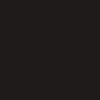

In [8]:
colors


In [9]:
detected_product

'T-shirt'

In [10]:
rec=image_analysis.get_recommendation()

In [11]:
rec

{'Casual été': {'Jean': [{'product_id': 'https://nestorevintage.fr/cdn/shop/files/IMG_8510.jpg?v=1734263492&width=2048'},
   {'product_id': 'https://nestorevintage.fr/cdn/shop/files/IMG_2131.jpg?v=1715528599&width=2048'},
   {'product_id': 'https://nestorevintage.fr/cdn/shop/files/22924F88-AC8D-4F9F-8EAA-7E04EBAC85ED.jpg?v=1737896499&width=2048'}],
  'Lunettes': []},
 'Casual hiver': {'Jean': [{'product_id': 'https://nestorevintage.fr/cdn/shop/files/IMG_8510.jpg?v=1734263492&width=2048'},
   {'product_id': 'https://nestorevintage.fr/cdn/shop/files/IMG_2131.jpg?v=1715528599&width=2048'},
   {'product_id': 'https://nestorevintage.fr/cdn/shop/files/22924F88-AC8D-4F9F-8EAA-7E04EBAC85ED.jpg?v=1737896499&width=2048'}],
  'Bonnet': [{'product_id': 'https://wasted.fr/cdn/shop/files/brow-beanie-reverse-prey-809917.jpg?v=1737638763'},
   {'product_id': 'https://wasted.fr/cdn/shop/files/brow-beanie-skylab-519514.jpg?v=1730547746'}]},
 'Sportswear': {'Jogging': [{'product_id': 'https://wasted.fr/c

In [18]:
import pandas as pd 
data_ex=pd.read_excel("data/data_preview_exploded.xlsx")

In [23]:
data_ex["Catégorie produit"].unique().tolist()

['T-shirt',
 'Hoodie',
 'Pull',
 'Jean',
 'Pantalon',
 'Jogging',
 'Veste',
 'Doudoune',
 'Jupe',
 'Bonnet',
 'Casquette',
 'Chapeau',
 'Short',
 'Veste ',
 'Sac bandoulière',
 'Sac à main',
 'Bob',
 'Chemise',
 'Pantalon habillé',
 'Chino',
 'short',
 'Blazer',
 'Robe',
 'Manteau',
 'Blouson',
 'Trench',
 'Cardigan',
 'Col roulé',
 'Top',
 'top',
 'Débardeur',
 'chemise',
 't shirt ',
 'body',
 't shirt',
 'jean',
 'pantalon habillé',
 'jupe',
 'sneakers',
 'botte',
 'Chaussures de ville',
 'bottes',
 'escarpin',
 'Bottes',
 'T-Shirt',
 'Écharpe',
 'Portefeuille',
 'Sac de voyage',
 'Lunettes',
 'Sac à dos']

In [43]:
prod=list(outfit["Outfit"].keys())

In [46]:
from Levenshtein import distance

def corriger_categorie(categorie, liste_produits):
    """Corrige les fautes de frappe dans une catégorie."""
    meilleure_correspondance = categorie
    distance_min = float('inf')

    for produit in liste_produits:
        dist = distance(categorie.lower(), produit.lower())
        if dist < distance_min:
            distance_min = dist
            meilleure_correspondance = produit

    return meilleure_correspondance

# Exemple d'utilisation
liste_produits = prod # Votre liste de produits
categorie_dataset = 'chausure ville'  # Exemple de catégorie avec faute de frappe

categorie_corrigee = corriger_categorie(categorie_dataset, liste_produits)
print(f"Catégorie corrigée : {categorie_corrigee}")

Catégorie corrigée : Chaussures de ville


In [34]:
data_copy=data_ex.copy()

In [47]:
data_copy['Catégorie produit'] = data_copy['Catégorie produit'].apply(lambda x : corriger_categorie(x,prod))


In [40]:
data_ex["Catégorie produit"].value_counts()

Catégorie produit
Hoodie                 753
T-shirt                480
Jean                   402
Pull                   382
Short                  152
T-Shirt                137
Veste                   99
Jogging                 90
Robe                    64
Pantalon                58
chemise                 56
Sac bandoulière         49
Bonnet                  46
Sac à main              45
Chapeau                 44
jupe                    43
Veste                   40
Cardigan                36
Bob                     30
short                   27
Chemise                 25
Portefeuille            24
jean                    21
Blazer                  20
Manteau                 19
Casquette               18
Pantalon habillé        18
t shirt                 15
Doudoune                15
Blouson                 14
top                     14
Écharpe                  8
Chaussures de ville      8
pantalon habillé         7
bottes                   7
sneakers                 6
Sac à dos 

In [48]:
data_copy["Catégorie produit"].value_counts()

Catégorie produit
Hoodie                 768
T-shirt                633
Jean                   423
Pull                   406
Short                  179
Veste                  139
Robe                    94
Jogging                 90
Chemise                 89
Cardigan                81
Manteau                 63
Pantalons               58
Bottes                  58
Sandales                49
Jupe                    45
Pantalon habillé        25
Polo                    21
Blazer                  20
Costume                 18
Blouson                 14
Chaussures de ville      8
Chinos                   8
Sneakers                 6
Col roulé                4
Tailleur                 2
Trench                   2
Robe de soirée           2
Escarpins                1
Name: count, dtype: int64

In [52]:
print(data_copy[data_copy["Catégorie produit"]=="Chaussures de ville"]["Photo produit 1"].tolist())

['https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dw1e981db8/images/packshot/Sandro_SFACH01136-20_F_P.jpg?sw=650&sh=650', 'https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dw1e981db8/images/packshot/Sandro_SFACH01136-20_F_P.jpg?sw=650&sh=650', 'https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dwb2989025/images/packshot/Sandro_SFACH01172-34_F_P.jpg?sw=650&sh=650', 'https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dwb2989025/images/packshot/Sandro_SFACH01172-34_F_P.jpg?sw=650&sh=650', 'https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dwb48c826b/images/packshot/Sandro_SFACH01180-16_F_P.jpg?sw=650&sh=650', 'https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dwb48c826b/images/packshot/

In [55]:
def get_level(prod,input):
    llm=ChatOpenAI(model="gpt-4o")
    prompt = f"""  

        Instructions :

        Vous êtes un expert en matching des textes. Votre tâche est matcher l'input avec une catégorie dans la liste donné.

        listes des catégories : 
        -------------------------
        {prod}
        -------------------------

        input : {input}
        Réponse : 
        """
    messages=[
    (
        "system",prompt,
    ),
 
    ]
    ai_msg=llm.invoke(messages)
    return ai_msg.content

    
    

In [57]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()
get_level(prod,"chau. ville")

'Chaussures de ville'